# Определение стоимости автомобилей

<font size = 4> **Описание проекта**
    
Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Для построения модели прогнозирования стоимости клиент предоставляет исторические данные: технические характеристики, комплектации и цены автомобилей. 
    
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<font size = 4> **Цель проекта**

Нам нужно построить модель машинного обучения для определения стоимости автомобиля (задача регрессии).   
Метрика качества работы модели: `RMSE`. Она должна быть меньше 2500.

<font size = 4> **План проекта**

**1.  Изучение данных.**  
  
1.1 Установим необходимые библиотеки.  
1.2 Выполним импорт нужных библиотек и методов работы с данными.  
1.3 Считываем данные из `CSV-файла` в датафрейм и сохраняем в переменную `df`.  
1.4 Выводим основную информацию о датафрейме с помощью метода `info()`.  
1.5 Выясним, как распределяются значения всех наших признаков.

    
**2.  Предобработка данных.**  
    
2.1  Удалим лишние признаки (столбцы).   
2.2  Проверим данные на наличие дубликатов.    
2.3  Удалим объекты с аномальными значениями признаков.  
2.4  Заполним пропуски в данных. 
     
    
**3.  Поиск зависимостей в данных.**  
    
3.1  Рассчитаем корреляцию Пирсона в данных.  
3.2  Рассчитаем Phik корреляцию для признаков.  
3.3  Изучим взаимосвязь цены автомобиля с несколькими признаками.   
    
    
**4.  Обучение моделей.**  
    
4.1  Разобьем данные на выборки.  
4.2  Выполним OHE для категориальных признаков.  
4.3  Выполним масштабирование признаков.  
4.4  Обучим модели на тренировочной выборке.  
4.5  Сравнение моделей.

    
**5.  Анализ итоговой модели.**  
    
5.1  Проверим качество модели на тестовой выборке.  
5.2  Проверим модель на адекватность.  
5.3  Построим кривые обучения модели.  
5.4  Оценим важность признаков для работы модели.
    
    
**6.  Общий вывод.**  

## Изучение данных

### Установим необходимые библиотеки.

In [ ]:
pip install phik

In [ ]:
pip install lightgbm

In [ ]:
pip install optuna

### Выполним импорт нужных библиотек и методов работы с данными. 

In [1]:
# Импорт стандартных библиотек
import warnings
import time

# Импорт сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import phik

# Отключение предупреждений
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
# Импорт моделей машинного обучения
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor

# Импорт метода подбора гиперпараметров случайным образом
from sklearn.model_selection import RandomizedSearchCV

# Импорт метрик
from sklearn.metrics import mean_squared_error

# Импорт способов работы с выборками
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.model_selection import (train_test_split,
                                     cross_val_score)

# Импорт метода исследования важности признаков
from sklearn.inspection import permutation_importance

# Импорт методов для построения кривых обучения
from sklearn.model_selection import (LearningCurveDisplay,
                                     learning_curve)

# Импорт модуля обработки изображений
from PIL import Image

# Объявление константы для воспроизводимости псевдослучайных значений 
RANDOM_STATE = 800

### Считываем данные из CSV-файла в датафрейм и сохраняем в переменную df.

In [3]:
try:
    df = pd.read_csv('d:/Data_science/Projects_jupiter/data/autos.csv')

except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
# Вывод 10 случайных строк таблицы
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
136147,2016-03-19 21:25:25,5499,small,2006,manual,75,fox,150000,2,petrol,volkswagen,no,2016-03-19 00:00:00,0,65553,2016-04-06 08:45:43
113832,2016-04-02 19:06:24,2500,wagon,2002,manual,102,passat,150000,3,petrol,volkswagen,no,2016-04-02 00:00:00,0,61118,2016-04-06 11:16:53
352348,2016-03-19 16:25:18,2299,coupe,1999,manual,170,3er,150000,11,petrol,bmw,no,2016-03-19 00:00:00,0,55411,2016-03-20 12:08:32
253308,2016-03-13 00:57:14,2200,NaN,2005,NaN,0,ka,60000,0,petrol,ford,NaN,2016-03-13 00:00:00,0,33129,2016-03-13 08:42:17
205350,2016-04-03 11:45:34,5500,NaN,1980,NaN,0,transporter,5000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,92551,2016-04-07 12:45:20
228753,2016-03-24 11:16:02,999,wagon,1999,manual,122,v40,150000,10,petrol,volvo,no,2016-03-22 00:00:00,0,61231,2016-03-29 04:47:08
75548,2016-04-01 20:41:01,1100,small,2001,manual,60,punto,150000,3,petrol,fiat,no,2016-04-01 00:00:00,0,80939,2016-04-05 17:27:02
13641,2016-03-10 19:38:52,2400,sedan,2001,manual,0,golf,150000,3,gasoline,volkswagen,no,2016-03-10 00:00:00,0,68766,2016-03-21 09:45:34
295447,2016-03-08 18:54:19,1600,sedan,1999,manual,110,a3,150000,6,gasoline,audi,yes,2016-03-08 00:00:00,0,89340,2016-04-07 14:56:28
54216,2016-03-27 19:58:10,5950,bus,2009,manual,143,5_reihe,150000,2,gasoline,mazda,no,2016-03-27 00:00:00,0,44807,2016-04-05 18:45:53


**Описание данных**

**Признаки**  
`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Gearbox` — тип коробки передач  
`Power` — мощность (л. с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля  
`Repaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты   
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя  

**Целевой признак**  
`Price` — цена (евро)  

### Выводим основную информацию о датафрейме с помощью метода info().

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Замечание:**  Признаки имеют численные и категориальные значения. Присутствуют пропуски.

### Выясним, как распределяются значения всех наших признаков.
Для удобства вывода графиков напишем функции. Для красоты вывода информации создадим класс `Color`. 

In [6]:
# Класс для форматирования текста на онове ANSI
class Color():
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [7]:
# Выбор признаков с определённым типом данных
integer_columns = df.select_dtypes(include=['int64']).columns
float_columns = df.select_dtypes(include=['float64']).columns
object_columns = df.select_dtypes(include=['object']).columns
# Вывод данных с помощью форматирования классом "Color"
print(Color.BOLD, 'Признаки с целочисленными значениями:', Color.END)
print( pd.Series(integer_columns))
print('--------------------------------------------')
print(Color.BOLD, 'Признаки с дробными значениями:', Color.END)
print(pd.Series(float_columns))
print('--------------------------------------------')
print(Color.BOLD, 'Признаки с категориальными значениями:', Color.END)
print(pd.Series(object_columns))
print('--------------------------------------------')

 Признаки с целочисленными значениями: 
0                Price
1     RegistrationYear
2                Power
3            Kilometer
4    RegistrationMonth
5     NumberOfPictures
6           PostalCode
dtype: object
--------------------------------------------
 Признаки с дробными значениями: 
Series([], dtype: object)
--------------------------------------------
 Признаки с категориальными значениями: 
0    DateCrawled
1    VehicleType
2        Gearbox
3          Model
4       FuelType
5          Brand
6       Repaired
7    DateCreated
8       LastSeen
dtype: object
--------------------------------------------


**Замечание:** Наши признаки имеют 2 типа данных: целые числа и объекты. Данные типа "объекты" относятся к категориальным признакам, но среди них имеются признаки с типом данных "дата и время" (`DateCrawled`, `DateCreated`, `LastSeen`).

In [8]:
# Функция для одновременного вывода графиков для численных признаков: гистограмма и "ящик с усами",
# а также подсчёта количества пропущенных значений
def box_hist(col, color):
    '''
    col - колонка (признак)
    color - цвет графика
    '''
    f, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={"height_ratios": (.15, .85)})
    x = sns.boxplot(col, ax=ax_box, color=color).set_title(f'Распределение значений признака {str(col.name)}', pad=20)
    y = sns.histplot(col, ax=ax_hist, color=color)
    ax_box.set(xlabel='')
    ax_hist.set(xlabel='Значения признака', ylabel='Количество данных')
    return print(Color.BOLD, Color.BLUE, 'Количество пропусков:', col.isna().sum(), Color.END)

In [9]:
# Функция для построения гистограммы для категориальных признаков и подсчета количества пропущенных значений
def hist(col, color):
    '''
    col - колонка (признак)
    color - цвет графика
    '''
    col.hist(bins=30, color=color);
    plt.title(f'Распределение значений признака {str(col.name)}');
    plt.xlabel('Значения признака');
    plt.ylabel('Количество данных');
    return print(Color.BOLD, Color.BLUE, 'Количество пропусков:', col.isna().sum(), Color.END)

#### Посмотрим как распределяются значения целочисленнго признака `Price`.

  Количество пропусков: 0 


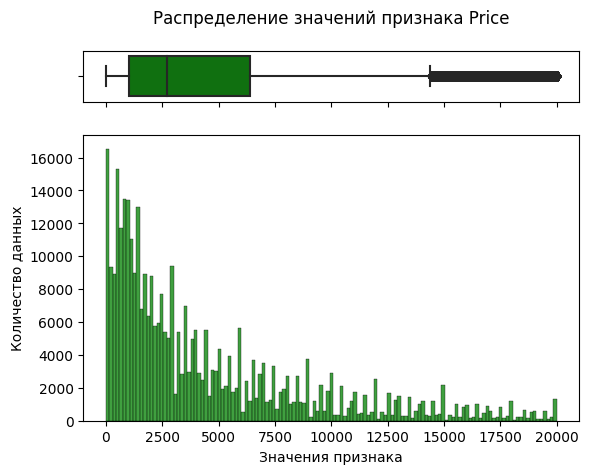

In [10]:
# Вывод графиков и количества пропусков
box_hist(df['Price'], 'green');

**Замечание:** Можно заметить, что у нас есть значения целевого признака равные 0 или очень близки к этому значению.

In [11]:
print('Количество автомобилей с ценой равной 0 евро:', len(df[df['Price'] == 0]))
print('Количество автомобилей с ценой от 0 до 100 евро:', len(df[(df['Price'] > 0) & (df['Price'] < 100)]))

Количество автомобилей с ценой равной 0 евро: 10772
Количество автомобилей с ценой от 0 до 100 евро: 2542


**Замечание:** Данные с ценой автомобиля равным 0 евро явно с ошибкой. Кроме того очень маловероятно, что есть автомобили с ценой менее 100 евро. Такие строки нам придётся удалить.

#### Посмотрим как распределяются значения целочисленнго признака `RegistrationYear`.

  Количество пропусков: 0 


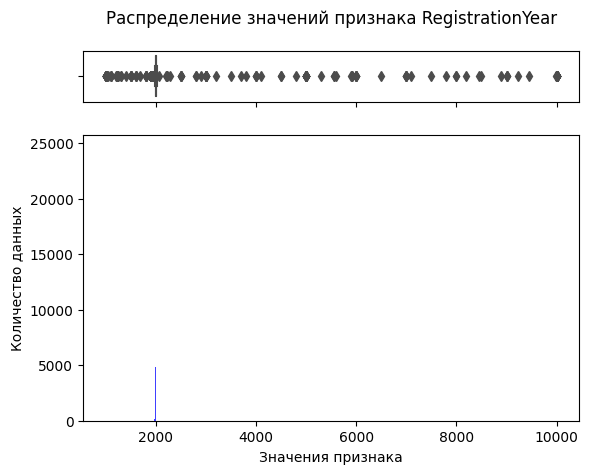

In [12]:
# Вывод графиков и количества пропусков
box_hist(df['RegistrationYear'], 'blue');

**Замечание:** Здесь явно присутствуют аномальные значения признака. Рассмотрим только автомобили зарегистрированные с 1930 по 2023 годы.

  Количество пропусков: 0 


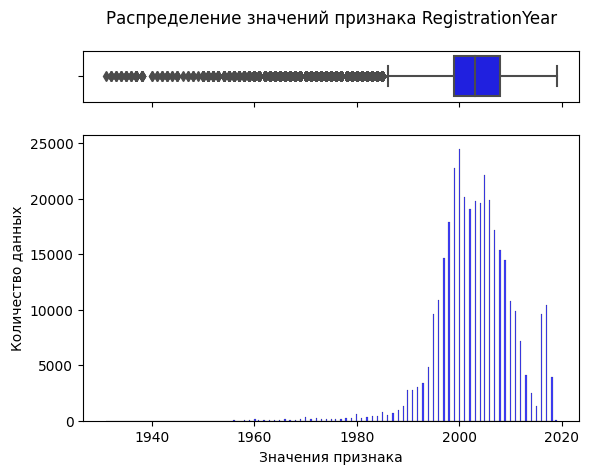

In [13]:
# Срез по данным таблицы
df_ry = (df[(df['RegistrationYear'] > 1930) & (df['RegistrationYear'] <= 2023)])
# Вывод графиков и количества пропусков
box_hist(df_ry['RegistrationYear'], 'blue');

In [14]:
print('Количество автомобилей с регистрацией до 1930 года:', len(df[df['RegistrationYear'] < 1930]))
print('Количество автомобилей с регистрацией после 2023 года:', len(df[df['RegistrationYear'] > 2023]))

Количество автомобилей с регистрацией до 1930 года: 183
Количество автомобилей с регистрацией после 2023 года: 105


**Замечание:** Для того чтобы адекватно оценивать стоимость автомобиля нам нужно представлять его возраст, поэтому данные с аномальными значениями этого признака нам придётся удалить.

#### Посмотрим как распределяются значения целочисленнго признака `Power`.

  Количество пропусков: 0 


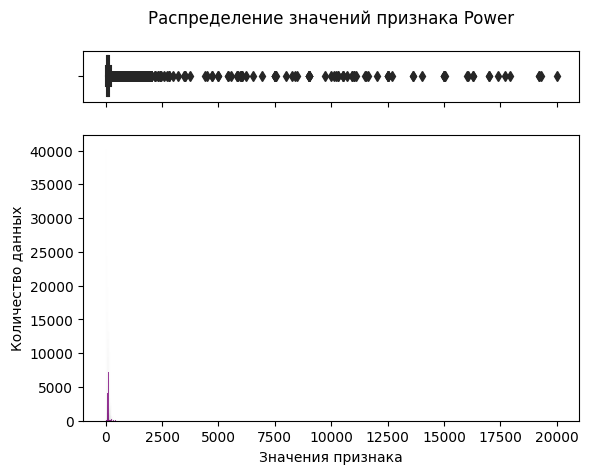

In [15]:
# Вывод графиков и количества пропусков
box_hist(df['Power'], 'purple');

**Замечание:** Здесь явно присутствуют аномальные значения признака. Рассмотрим только автомобили с мощностью от 10 до 1600 л.с.

  Количество пропусков: 0 


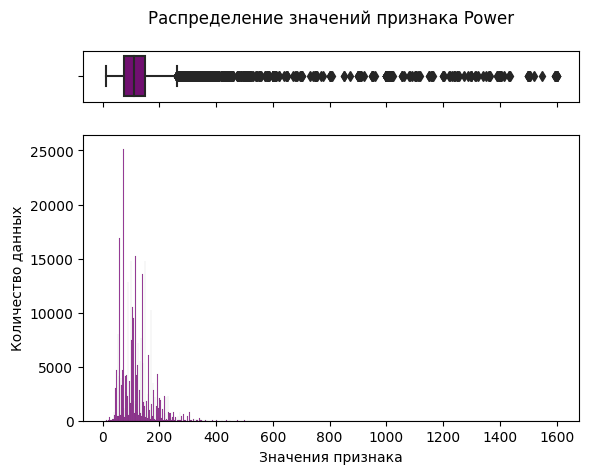

In [16]:
# Срез по данным таблицы
df_pow = (df[(df['Power'] > 10)&(df['Power'] <= 1600)])
# Вывод графиков и количества пропусков
box_hist(df_pow['Power'], 'purple');

In [17]:
print('Количество автомобилей с мощностью двигателя меньше 10 л.с.:', len(df[df['Power'] < 10]))
print('Количество автомобилей с мощностью двигателя больше 1600 л.с.:', len(df[df['Power'] > 1600]))

Количество автомобилей с мощностью двигателя меньше 10 л.с.: 40445
Количество автомобилей с мощностью двигателя больше 1600 л.с.: 179


**Замечание:** Самые "мощные" автомобили, на данный момент, имеют мощность двигателя около 1600 л.с., а самые "слабые" едва ли могут иметь мощность менее 10 л.с. Мы не можем доверять данным с мощностью двигателя автомобиля выходящим за эти рамки.

#### Посмотрим как распределяются значения целочисленнго признака `Kilometer`.

  Количество пропусков: 0 


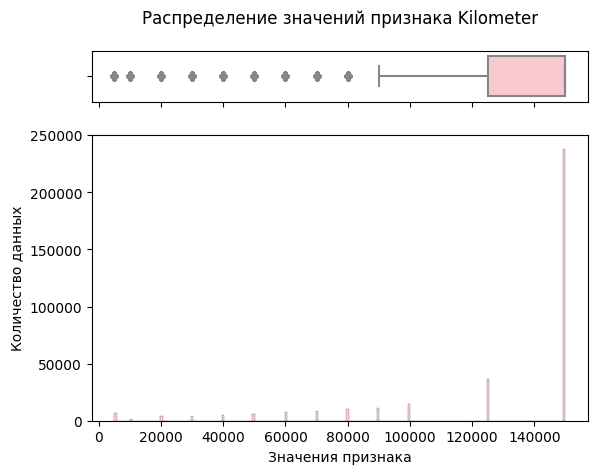

In [18]:
# Вывод графиков и количества пропусков
box_hist(df['Kilometer'], 'pink');

**Замечание:** В основном в наших данных, автомобили с довольно большим пробегом.

#### Посмотрим как распределяются значения категориального признака `RegistrationMonth`.

  Количество пропусков: 0 


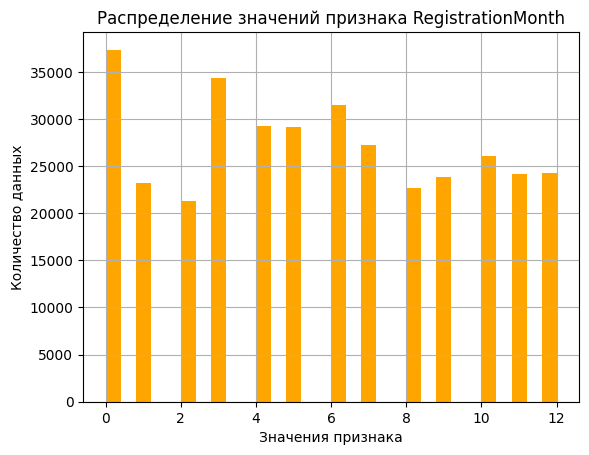

In [19]:
# Вывод графика и количества пропусков
hist(df['RegistrationMonth'], 'Orange');

**Замечание:** Данные этого признака выглядят адекватно. Данные распределены довольно равномерно.

#### Посмотрим как распределяются значения целочисленнго признака `NumberOfPictures`.

  Количество пропусков: 0 


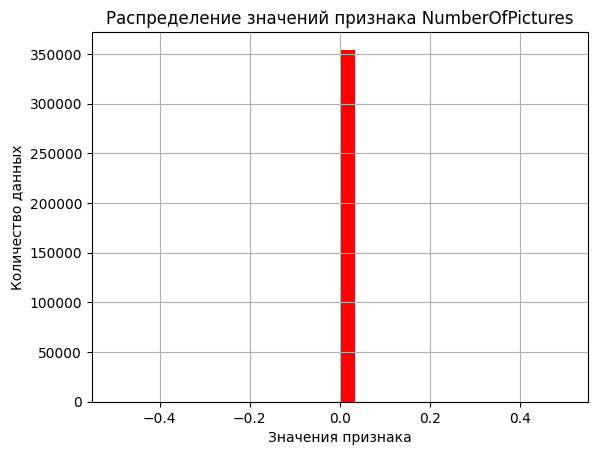

In [20]:
# Вывод графика и количества пропусков
hist(df['NumberOfPictures'], 'Red');

In [21]:
# Подсчёт количества значений признака
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

**Замечание:** Все значения нули, значит лучше удалить этот признак полностью.

#### Посмотрим как распределяются значения целочисленнго признака `PostalCode`.

  Количество пропусков: 0 


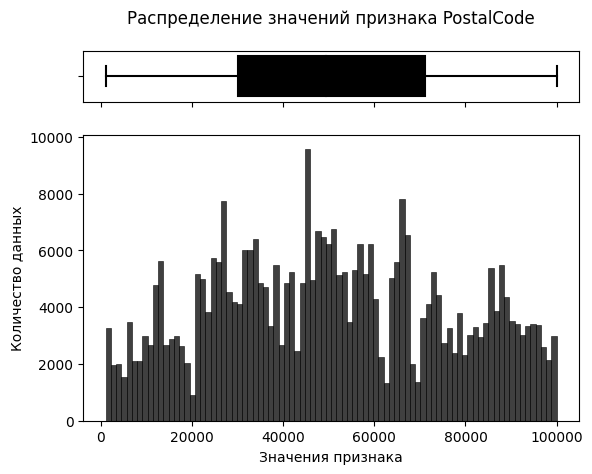

In [22]:
# Вывод графиков и количества пропусков
box_hist(df['PostalCode'], 'Black');

**Замечание:** Данные распределены достаточно равномерно.

#### Посмотрим как распределяются значения категориального признака `VehicleType`.

  Количество пропусков: 37490 


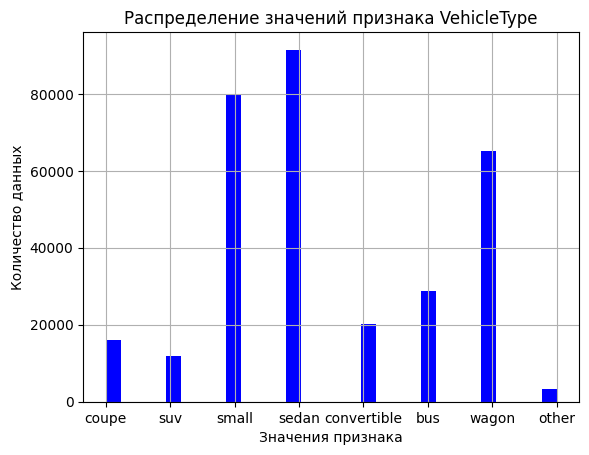

In [23]:
# Вывод графика и количества пропусков
hist(df['VehicleType'], 'blue')

**Замечание:** Больше всего объявлений автомобилей с типом кузова седан.

#### Посмотрим как распределяются значения категориального признака `Gearbox`.

  Количество пропусков: 19833 


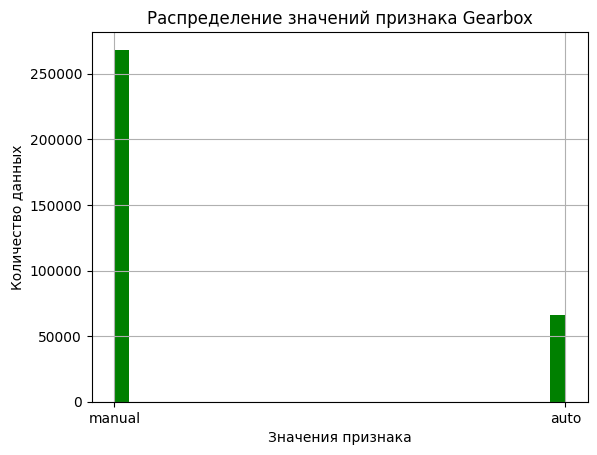

In [24]:
# Вывод графика и количества пропусков
hist(df['Gearbox'], 'green')

**Замечание:** Автомобилей с ручной коробкой передач больше.

#### Посмотрим как распределяются значения категориального признака `Model`.

  Количество пропусков: 19705 
  Количество уникальных моделей авто: 251 


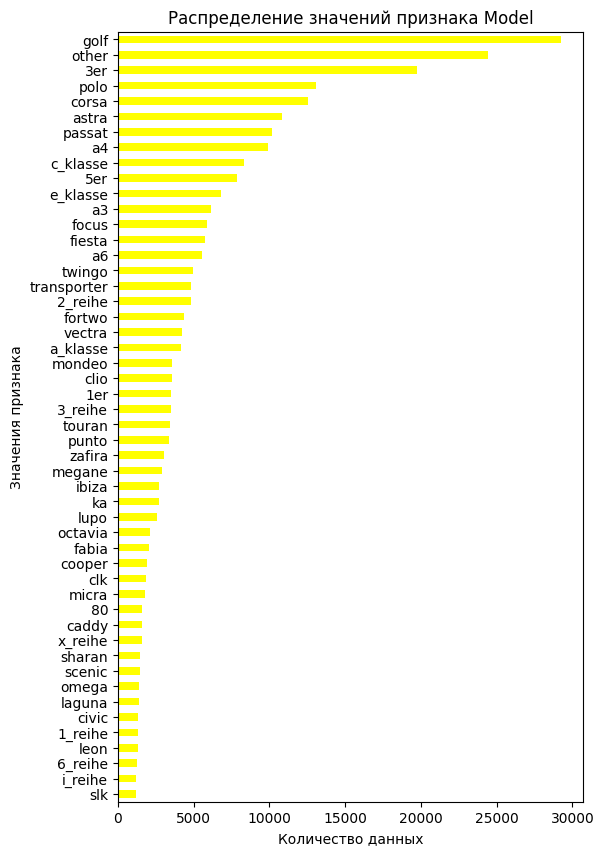

In [25]:
# Построение гистограммы для 50 наиболее популярных моделей
plt.figure(figsize=(6, 10))
df['Model'].value_counts(ascending=True).tail(50).plot(kind='barh', color='yellow');
plt.title(f'Распределение значений признака Model');
plt.xlabel('Количество данных');
plt.ylabel('Значения признака');
# Подсчет количества пропущенных значений
print(Color.BOLD, Color.BLUE, 'Количество пропусков:', df['Model'].isna().sum(), Color.END)
# Подсчет уникальных значений признака
print(Color.BOLD, Color.GREEN, 'Количество уникальных моделей авто:', len(df['Model'].unique()), Color.END)

**Замечание:** У нас 251 различных моделей авто. Самая популярная - `golf`. Много пропусков и заполненных полей значением `other`.

#### Посмотрим как распределяются значения категориального признака `FuelType`.

  Количество пропусков: 32895 


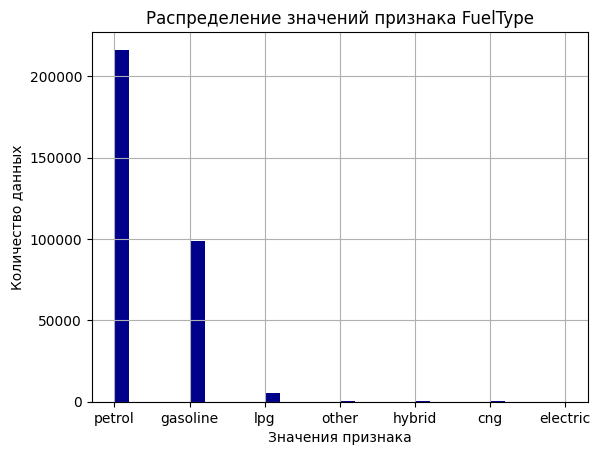

In [26]:
# Вывод графика и количества пропусков
hist(df['FuelType'], 'darkblue')

**Замечание:** В основном присутствуют автомобили с бензиновым двигателем. Причём `petrol` и `gasoline` здесь означают одно и тоже.

#### Посмотрим как распределяются значения категориального признака `Brand`.

  Количество пропусков: 0 
  Количество уникальных автомобильных брендов: 40 


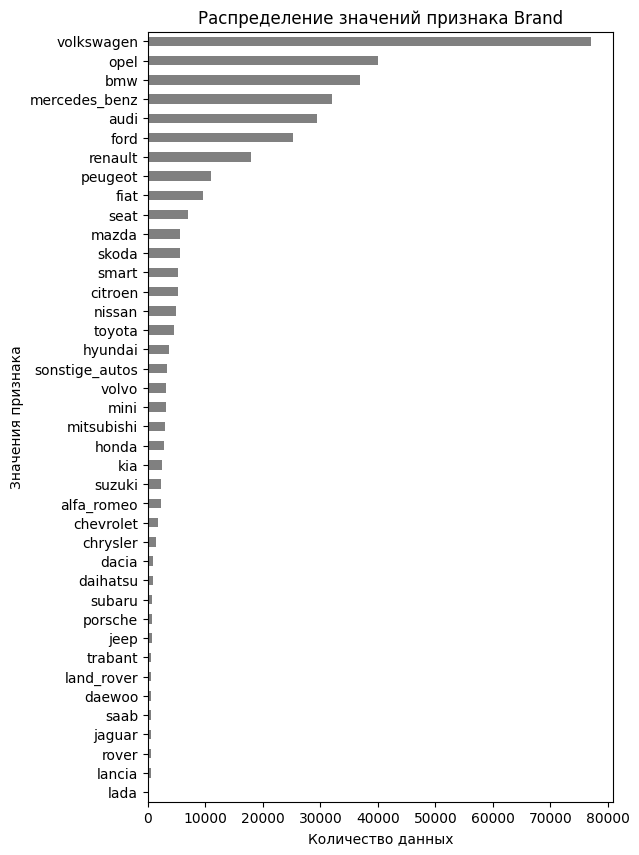

In [27]:
# Построение гистограммы для 50 наиболее популярных моделей
plt.figure(figsize=(6, 10))
df['Brand'].value_counts(ascending=True).plot(kind='barh', color='gray');
plt.title(f'Распределение значений признака Brand');
plt.xlabel('Количество данных');
plt.ylabel('Значения признака');
# Подсчет количества пропущенных значений
print(Color.BOLD, Color.BLUE, 'Количество пропусков:', df['Brand'].isna().sum(), Color.END)
# Подсчет уникальных значений признака
print(Color.BOLD, Color.GREEN, 'Количество уникальных автомобильных брендов:', len(df['Brand'].unique()), Color.END)

**Замечание:** Самые распространённые бренды: `volkswagen`, `opel`, `bmv`, `mercedes`, `audi`.

#### Посмотрим как распределяются значения категориального признака `Repaired`.

  Количество пропусков: 71154 


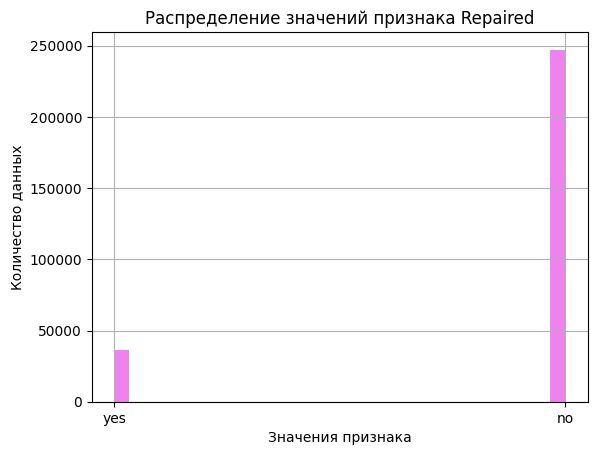

In [28]:
# Вывод графика и количества пропусков
hist(df['Repaired'], 'violet')

**Замечание:** Большая часть автомобилей не ремонтировалась. Однако здесь довольно много пропусков. Также часто данная информация не очень правдива.

#### Посмотрим как распределяются значения признака даты и времени `DateCrawled`.

  Количество пропусков: 0 


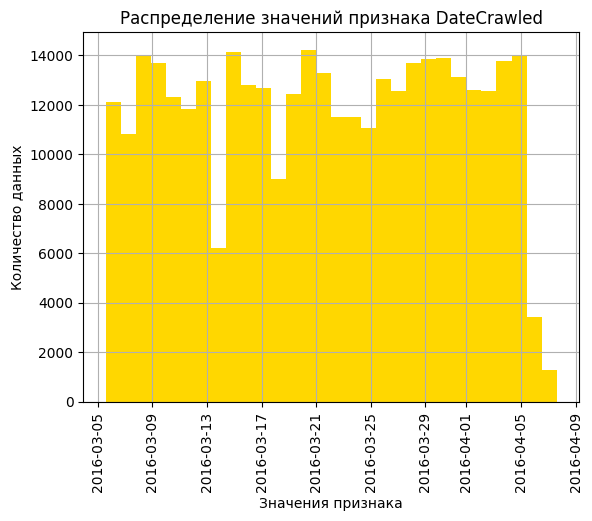

In [29]:
# Перевод значений признака в формат даты
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
# Вывод графика и количества пропусков
hist(df['DateCrawled'], 'gold')
plt.xticks(rotation=90);

**Замечание:** Судя по данным, анкеты из базы скачивались в 2016 году в марте и в апреле.

#### Посмотрим как распределяются значения признака даты и времени `DateCreated`.

  Количество пропусков: 0 


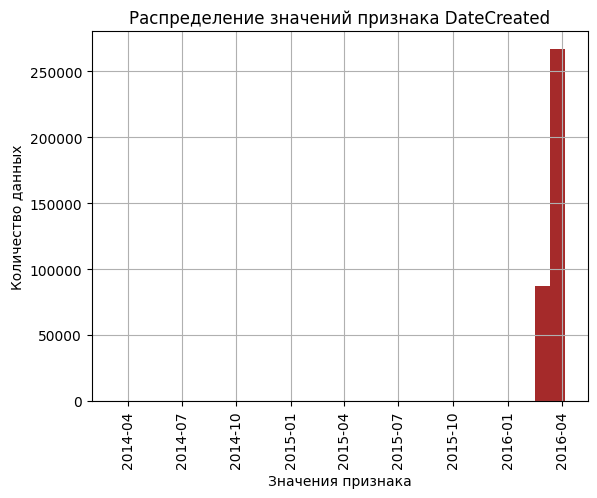

In [30]:
# Перевод значений признака в формат даты
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
# Вывод графика и количества пропусков
hist(df['DateCreated'], 'brown')
plt.xticks(rotation=90);

**Замечание:** Судя по данным, анкеты создавались начиная с апреля 2014 года вплоть до апреля 2016 года. Причем большая часть из них создавалась в 2016 году.

#### Посмотрим как распределяются значения признака даты и времени `LastSeen`.

  Количество пропусков: 0 


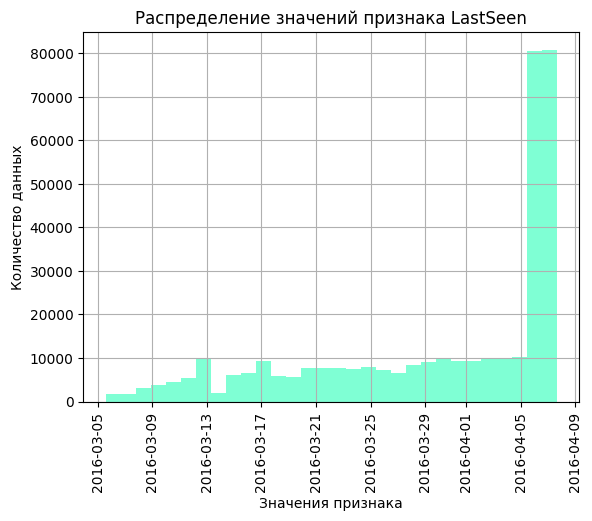

In [31]:
# Перевод значений признака в формат даты
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')
# Вывод графика и количества пропусков
hist(df['LastSeen'], 'aquamarine')
plt.xticks(rotation=90);

**Замечание:** Мы видим,что последняя активность всех пользователей в наших данных была в 2016 году с марта по сентябрь.

## Предобработка данных
В исходных данных достаточно много пропущенных и аномальных значений. Для адекватных предсказаний модели машинного обучения, нам нужно очистить данные от значений, которые не соответствуют действительности. Также можно попробовать заполнить пропущенные значения, там где это возможно.

### Удалим лишние признаки (столбцы).
В признаке `NumberOfPictures` все значения нули и поэтому он не несёт в себе никакой предсказательной способности, значит мы можем полностью удалить этот признак.  

Признаки даты и времени: `DateCrawled`, `DateCreated`, `LastSeen` мы можем также удалить. Они не несут причинно - следственной связи для целевого признака `Price`. Кроме того они распределены плотно, что так же лишь может ухудшить результаты предсказания модели. Например, все объявления скачивались в марте и апреле 2016 года. Предположительно информация о том сколько времени "висит" объявление поможет повысить качество прогноза. Нужно уточнить у заказчика, возможно ли вывести её из существующих данных или получить от него дополнительный признак.

Также удалим признак `PostalCode`. Он имеет очень много разных значений, плюс имеет целочисленный тип с ложным порядком (будто одно местоположение больше другого). В дальнейшем можно попытаться преобразовать его в местоположение пользователя (например страна и город в которых продаётся автомобиль).

In [32]:
# Создание таблицы с выбранными столбцами
df_clear = df[['Price',
               'VehicleType',
               'RegistrationYear',
               'Gearbox',
               'Power',
               'Model',
               'Kilometer',
               'RegistrationMonth',
               'FuelType',
               'Brand',
               'Repaired']]

### Проверим данные на наличие дубликатов.

In [33]:
print('Количество объектов с одинаковыми значениями: ', df_clear.duplicated().sum())
print('-' * 60)
print('Всего строк:', len(df_clear))

Количество объектов с одинаковыми значениями:  27543
------------------------------------------------------------
Всего строк: 354369


**Замечание:**  Получилось довольно много дубликатов. Может быть из-за того, что одно и тоже объявление скачивали несколько раз.

In [34]:
# Удалим строки - дубликаты
df_clear = df_clear.drop_duplicates()
print('Осталось строк:', len(df_clear))

Осталось строк: 326826


**Замечание:**  Мы удалили 27543 строк - дубликатов.

### Удалим объекты с аномальными значениями признаков.

#### Рассмотрим значения признака `Price`.
Оставим только объекты со значением цены авто больше 100 евро, так как цена авто не может равняться 0 или быть очень низкой.

In [35]:
# Срез таблицы с данными по условию
df_clear_price = df_clear[df_clear['Price'] > 100]
print('Удалили строк:', len(df_clear) - len(df_clear_price))
print('Осталось строк:', len(df_clear_price))

Удалили строк: 12767
Осталось строк: 314059


**Замечание:**  Нам пришлось удалить 12767 строк.

#### Рассмотрим значения признака `Power`.
Оставим только объекты со значением мощности двигателя от 10 л.с до 1600 л.с. Самые современные авто, на данный момент, имеют двигатели мощностью не более 1600 л.с. Маловероятно, что автомобиль может имеет мощность двигателя менее 10 л.с.

In [36]:
# Срез таблицы с данными по условию
df_clear_power = df_clear_price[(df_clear_price['Power'] > 10) & (df_clear_price['Power'] < 1600)]
print('Удалили строк:', len(df_clear_price) - len(df_clear_power))
print('Осталось строк:', len(df_clear_power))

Удалили строк: 32658
Осталось строк: 281401


**Замечание:**  Нам пришлось удалить ещё 32658 строк.
Строк с нулевой мощностью достаточно много, можно поработать с ними, как с пропусками и заполнить, например, медианой по модели авто. Однако, у одной и той же модели автомобиля может быть двигатель с разной мощностью и объёмом. Данных всё ещё довольно много, поэтому оставим всё как есть.

#### Рассмотрим значения признака `RegistrationYear`.
Основная масса автомобилей должна быть зарегистрирована не ранее 1930 года и не позднее 2023 года. Однако по условию задачи, анкеты скачивались в марте и апреле 2016 года. Здесь явное противоречие. Мы не можем иметь объявления с автомобилями старше апреля 2016 года. Здесь присутствует ошибка. Лучше выяснить эту информацию у заказчика.  
Поэтому оставим объявления с датой регистрации автомобилей начиная с 1930 года и заканчивая апрелем 2016 года.

In [37]:
# Выбор объявлений с регистрацией авто между 1930 и 2016 годами
df_clear_year = df_clear_power[(df_clear_power['RegistrationYear'] < 2016) & (df_clear_power['RegistrationYear'] > 1930)]
print('Удалили строк до 2016 года:', len(df_clear_power) - len(df_clear_year))
print('Осталось строк до 2016 года:', len(df_clear_year))
# Выбор авто зарегистрированные в 2016 году
df_clear_year_2016 = df_clear_power[df_clear_power['RegistrationYear'] == 2016]
print('Количество объявлений с регистрацией авто в 2016 году:', len(df_clear_year_2016))
# Выбор авто зарегистрированные в 2016 году до мая месяца
df_clear_year_2016_04 = df_clear_year_2016[df_clear_year_2016['RegistrationMonth'] < 5]
print('Количество объявлений с регистрацией авто в 2016 году с января по апрель:', len(df_clear_year_2016_04))
# Объединение объявлений с регистрацией авто с 1930 по 2015 годы и с регистрацией в 2016 году с января по апрель
df_clear_year = pd.concat([df_clear_year, df_clear_year_2016_04])
print('--------------------------------------------------------------------------------')
print('Стало строк:', len(df_clear_year))
print('Всего удалили строк :', len(df_clear_power) - len(df_clear_year))

Удалили строк до 2016 года: 15816
Осталось строк до 2016 года: 265585
Количество объявлений с регистрацией авто в 2016 году: 6069
Количество объявлений с регистрацией авто в 2016 году с января по апрель: 2852
--------------------------------------------------------------------------------
Стало строк: 268437
Всего удалили строк : 12964


**Замечание:**  Нам пришлось удалить ещё 12964 строк.

### Заполним пропуски в данных.

In [38]:
# Рассчёт количества пропущенных значений
df_clear.isna().sum()

Price                    0
VehicleType          35249
RegistrationYear         0
Gearbox              17578
Power                    0
Model                18532
Kilometer                0
RegistrationMonth        0
FuelType             31122
Brand                    0
Repaired             66427
dtype: int64

**Замечание:** Мы не можем достоверно заполнить ни один из пропусков каким либо значением, так как автомобили могут иметь различные комплектации. Например одна и таж модель автомобиля может иметь либо ручную, либо автоматическую коробку передач.

Пропусков довольно много поэтому удалять строки не будем.  
Так как пропущенные значения находятся среди категориальных признаков, то пропуски заполним значением `no_info`.

In [39]:
# Заполнение пропусков
df_clear_fna = df_clear.fillna('no_info')
# Рассчёт количества пропущенных значений 
df_clear_fna.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

**Замечание:**  Мы заполнили все пропуски в данных заглушкой `no_info`.  
Отметим, что в колонках `VehicleType`, `Model`, `FuelType` есть значение `other`, которое можно было объединить с новой категорией (например, пропуски заполнять значением `other`). Но если возможно восстановить каким либо образом пропущенные данные, например, общаясь с заказчиком или коллегами, то лучше их не смешивать. Поэтому оставим `no_info`.

## Поиск зависимостей в данных

### Рассчитаем корреляцию Пирсона в данных.

In [40]:
# Функция вывода корреляции Пирсона с импользованием различных цветов в зависимости от значений
def pirson(data):
    return (data.corr().style.applymap(lambda v: 'opacity: 20%' if (v < 0.1) and (v > -0.1) 
                                       else 'opacity: 70%; color: green; background-color: yellow;')
                             .applymap(lambda v: None if (v < 0.3) and (v > -0.3) 
                                       else 'opacity: 100%; color: green; background-color: lawngreen;')
                             .applymap(lambda v: None if (v < 0.7) and (v > -0.7)
                                       else 'color: black; background-color: red;')
                             .applymap(lambda v: 'color: blue; background-color: orange;' if (v == 1) 
                                       else None))

In [41]:
pirson(df_clear_fna)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.026404,0.152087,-0.329761,0.108230
RegistrationYear,0.026404,1.000000,-0.000758,-0.053151,-0.011665
Power,0.152087,-0.000758,1.000000,0.024775,0.041536
Kilometer,-0.329761,-0.053151,0.024775,1.000000,0.009727
RegistrationMonth,0.108230,-0.011665,0.041536,0.009727,1.000000


**Дополнение:** На платформе `GitHub` на данный момент не получается отобразить форматирование цветами для таблиц из `Pandas`.
Поэтому для того, чтобы можно было ознакомится с результатом данных преобразований, ниже приведён скриншот. Под ним находится ссылка на эту картинку в репозитории.

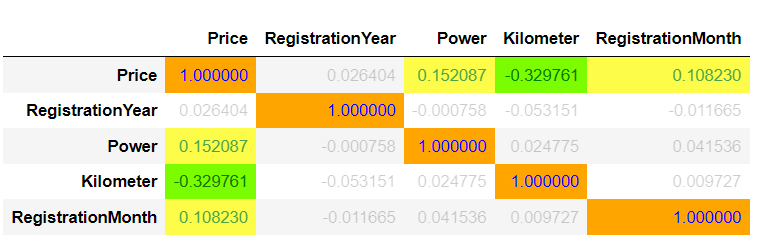

In [42]:
# Отображение скриншота работы функции pirson(df_clear_fna)
figure_1 = 'screenshots/Pirson.png'
img_figure_1 = Image.open(figure_1)
img_figure_1

**Замечание:**  Корреляция Пирсона показывает линейную связь числовых признаков.   

Тип связей отображён цветами:
- жёлтый цвет - слабая связь,
- зелёный цвет - средняя связь,
- красный цвет - сильная связь.

![avatar](https://www.ok-t.ru/studopediaru/baza17/1942458671852.files/image012.gif)

  
Здесь мы видим лишь умеренную и слабую связь.

### Рассчитаем Phik корреляцию для признаков.

In [43]:
# Функция вывода Phik корреляции с импользованием различных цветов в зависимости от значений
def phik(data):
    return (data.phik_matrix().style.applymap(lambda v: 'opacity: 20%' if (v < 0.1) and (v > -0.1)
                                              else 'opacity: 70%; color: green; background-color: yellow;')
                                    .applymap(lambda v: None if (v < 0.3) and (v > -0.3)
                                              else 'opacity: 100%; color: green; background-color: lawngreen;')
                                    .applymap(lambda v: None if (v < 0.7) and (v > -0.7)
                                              else 'color: black; background-color: red;')
                                    .applymap(lambda v: 'color: blue; background-color: orange;' if (v == 1)
                                              else None))

In [44]:
phik(df_clear_fna)

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Price,1.000000,0.278357,0.013617,0.303291,0.005820,0.569118,0.307633,0.182005,0.267038,0.354632,0.368640
VehicleType,0.278357,1.000000,0.041353,0.509205,0.010459,0.890148,0.241735,0.194139,0.428640,0.579832,0.440913
RegistrationYear,0.013617,0.041353,1.000000,0.073591,0.090159,0.050082,0.228476,0.030951,0.038852,0.050464,0.036738
Gearbox,0.303291,0.509205,0.073591,1.000000,0.008623,0.625757,0.076199,0.262828,0.339603,0.515031,0.469037
Power,0.005820,0.010459,0.090159,0.008623,1.000000,0.000000,0.000000,0.003167,0.011350,0.003581,0.012215
Model,0.569118,0.890148,0.050082,0.625757,0.000000,1.000000,0.432525,0.188876,0.543447,0.997740,0.317979
Kilometer,0.307633,0.241735,0.228476,0.076199,0.000000,0.432525,1.000000,0.055180,0.153123,0.275634,0.227692
RegistrationMonth,0.182005,0.194139,0.030951,0.262828,0.003167,0.188876,0.055180,1.000000,0.191862,0.099954,0.292450
FuelType,0.267038,0.428640,0.038852,0.339603,0.011350,0.543447,0.153123,0.191862,1.000000,0.323940,0.265703
Brand,0.354632,0.579832,0.050464,0.515031,0.003581,0.997740,0.275634,0.099954,0.323940,1.000000,0.159523


**Дополнение:** На платформе `GitHub` на данный момент не получается отобразить форматирование цветами для таблиц из `Pandas`.
Поэтому для того, чтобы можно было ознакомится с результатом данных преобразований, ниже приведён скриншот. Под ним находится ссылка на эту картинку в репозитории.

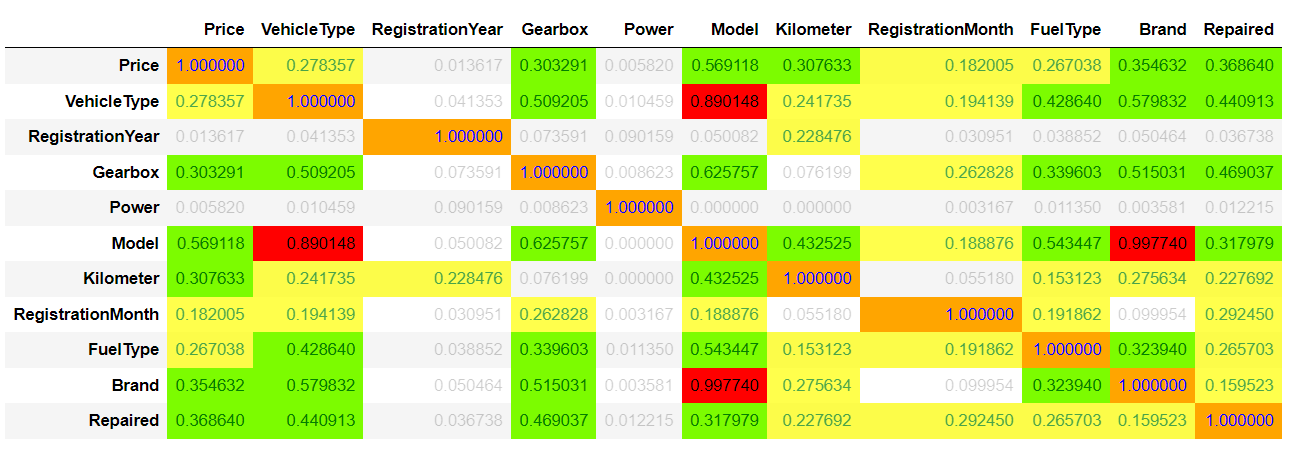

In [45]:
# Отображение скриншота работы функции phik(df_clear_fna)
figure_2 = 'screenshots/Phik.png'
img_figure_2 = Image.open(figure_2)
img_figure_2

**Замечание:**  Phik корреляция позволяет заметить нелинейную связь для всех типов данных.  

Тип связей отображён цветами:
- жёлтый цвет - слабая связь,
- зелёный цвет - средняя связь,
- красный цвет - сильная связь.

![avatar](https://www.ok-t.ru/studopediaru/baza17/1942458671852.files/image012.gif)

Большинство признаков коррелируют умеренно или слабо.  
Мы видим сильную корреляцию между признаками `Model`и `VehicleType`. Что вполне объяснимо. 

Практически на 100 % коррелируют признаки `Model`и `Brand`, что тоже логично. Однако такая сильная корреляция может пойти во вред при попытке построить некоторые типы моделей машинного обучения. Возможно, нам придётся один из этих признаков удалить. Всё зависит от того, как будет работать наша модель предсказаний.

### Изучим взаимосвязь цены автомобиля с несколькими признаками. 
Для удобства анализа создадим функцию.

In [46]:
# Функция создания сводной таблицы и построения столбчатого графика
def pivot_bar(data, column_x, column_y):
    '''
    data - таблица
    column_x - столбец индекса (ключи для группировки)
    column_y - столбец значений (агрегируемые значения)
    '''
    # Создание сводной таблицы
    df_pivot = (data.pivot_table(index=column_x,
                                 values=column_y,
                                 aggfunc=['mean', 'median', 'count'])
                    .round(2)
                    .reset_index())
    # Переименование столбцов для удобства (замена мультииндекса)
    df_pivot.columns = [column_x, f'{column_y}_mean', f'{column_y}_median', f'Count']
    display(df_pivot)
    # Построение столбчатого графика
    plt.figure(figsize=(8, 4))
    plt.bar(df_pivot[column_x],
            df_pivot[f'{column_y}_mean'])
    plt.title(f'Зависимость {column_y}_mean от {column_x}', size=15)
    plt.xlabel(column_x)
    plt.ylabel(f'{column_y}_mean')
    plt.show()

#### Рассмотрим зависимость цены автомобиля от признака `VehicleType`.

,VehicleType,Price_mean,Price_median,Count
0,bus,5443.83,4200,26795
1,convertible,6806.49,5499,18752
2,coupe,6009.33,3950,15120
3,no_info,2413.31,1200,35249
4,other,3562.63,2200,3173
5,sedan,4716.51,2990,83602
6,small,2680.03,1500,73496
7,suv,8924.20,8250,10977
8,wagon,4848.70,3150,59662


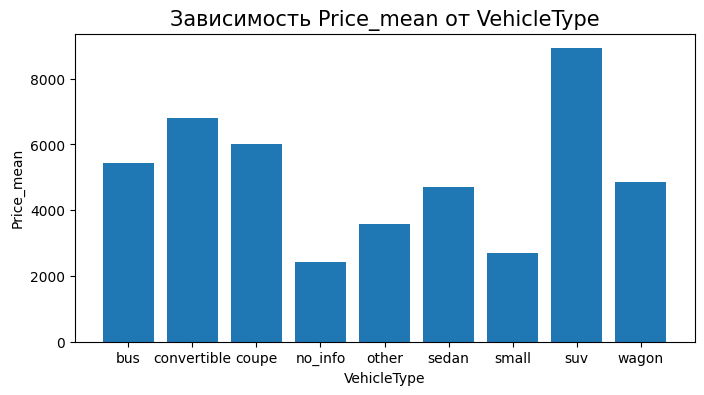

In [47]:
pivot_bar(df_clear_fna, 'VehicleType', 'Price')

**Замечание:**  Самый дорогой тип автомобиля - `suv` (sport utility vehicle).  
Автомобили с незаполненными данными (`no_info` и `other`) самые дешёвые. Судя по средней цене, тип этих автомобилей `small`, `sedan` или `wagon`.

#### Рассмотрим зависимость цены автомобиля от признака `Gearbox`.

,Gearbox,Price_mean,Price_median,Count
0,auto,6778.42,5400,61113
1,manual,3970.96,2450,248135
2,no_info,2257.08,1000,17578


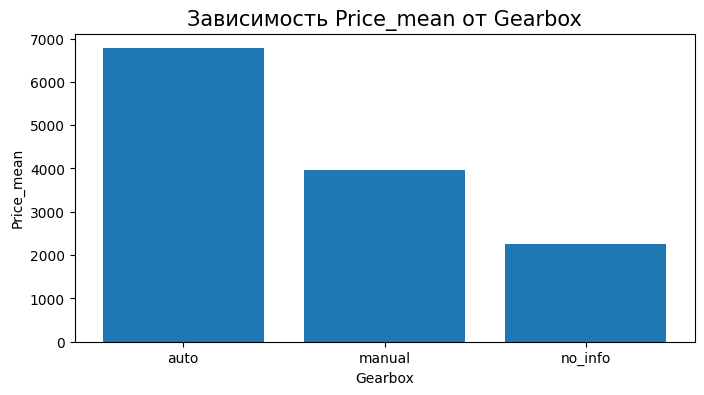

In [48]:
pivot_bar(df_clear_fna, 'Gearbox', 'Price')

**Замечание:**  Как и ожидалось автомобили с автоматической коробкой передач дороже. Так же можно предположить, что автомобили с пропущенной информацией в большинстве своём имеют ручную коробку передач.

#### Рассмотрим зависимость цены автомобиля от признака `Repaired`.

,Repaired,Price_mean,Price_median,Count
0,no,5296.36,3690,225970
1,no_info,2655.87,1390,66427
2,yes,1917.56,900,34429


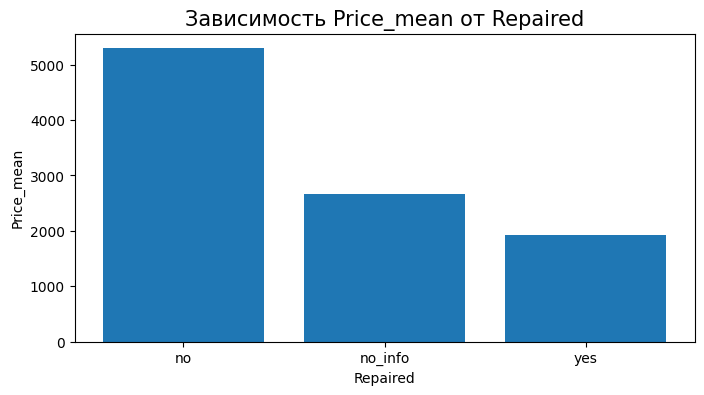

In [49]:
pivot_bar(df_clear_fna, 'Repaired', 'Price')

**Замечание:**  В среднем автомобили подвергшиеся ремонту дешевле, что вполне логично. Похоже на то что в объявлениях с пропусками больше автомобилей после ремонта.

## Обучение моделей
Перед обучением моделей подготовим данные.   
Во время работы (обучение и предсказание) моделей будем замерять время.

### Разобьем данные на выборки.

In [50]:
# Создадим переменные для признаков и для целевого признака
df_target = df_clear_fna['Price']
df_features = df_clear_fna.drop(['Price'], axis=1)
# Разобьем наши данные на 2 выборки: тренировочную и тестовую в соотношении 75:25
features_train, features_test, target_train, target_test = train_test_split(df_features,
                                                                            df_target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

In [51]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(245119, 10)
(81707, 10)
(245119,)
(81707,)


**Замечание:** В результате мы разбили наши данные на 2 выборки: тренировочную и тестовую, в соотношении 75:25. Для каждой выборки мы создали переменные для признаков и целевого признака.

### Выполним OHE для категориальных признаков.
Для того чтобы не угодить в дамми-ловушку и не создать проблеммы мультиколлинеарности удалим для каждого признака по одному (первому) столбцу из полученных новых.
Для кодирования используем `OneHotEncoder` из `sklearn`. Обучать кодировщик будем на тренировочной выборке.

In [52]:
# Сохраниние названий категориальных и численных признаков в списки
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']
num_cols = ['RegistrationYear', 'Power', 'Kilometer' ]

In [53]:
# Инициализация кодировщика
ohe_encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
# Обучение и кодировка категориальных признаков
data_train = ohe_encoder.fit_transform(features_train[cat_cols])
features_train_cat_ohe = pd.DataFrame(data_train,
                                      columns=ohe_encoder.get_feature_names_out(cat_cols),
                                      index=features_train.index)
# Объединение числовых и категориальных признаков в одну таблицу
features_train_ohe = pd.merge(features_train[num_cols],
                              features_train_cat_ohe,
                              how='outer',
                              left_index=True,
                              right_index=True)
features_train_ohe.head(3)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_no_info,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no_info,Repaired_yes
243564,2001,204,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
212243,2005,109,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67344,1990,45,20000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [54]:
# Кодировка категориальных признаков
data_test = ohe_encoder.transform(features_test[cat_cols])
features_test_cat_ohe = pd.DataFrame(data_test,
                                     columns=ohe_encoder.get_feature_names_out(cat_cols),
                                     index=features_test.index)
# Объединение числовых и категориальных признаков в одну таблицу
features_test_ohe = pd.merge(features_test[num_cols],
                             features_test_cat_ohe,
                             how='outer',
                             left_index=True,
                             right_index=True)
features_test_ohe.head(3)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_no_info,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no_info,Repaired_yes
117794,2005,0,150000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
68387,1990,116,80000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38861,2009,160,80000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Проверка совпадения признаков
(features_train_ohe.columns == features_test_ohe.columns).sum()

323

**Замечание:**  Получилось 323 столбца.
Если в тестовых данных появится новое категориальное значение, то кодировщик не создаст дополнительного признака. Если ситуация получится обратная, то в тестовой выборке во всех значениях такого признака будут стоять нули.

### Выполним масштабирование признаков.
Для работы линейных моделей масштабирование может сыграть положительную роль.  
Для "деревянных" моделей масштабирование можно не проводить.  
Чтобы не допустить утечки данных обучим модель масштабирования только на тренировочных данных.

In [56]:
# Создание объекта структуры масштабирования признаков (метод стандартизации)
scaler = StandardScaler()
# Настройка объекта на тренировочной выборке
scaler.fit(features_train_ohe[num_cols])
# Копирование исходных таблиц в новые переменные
features_train_scal = features_train_ohe.copy()
features_test_scal = features_test_ohe.copy()
# Приведение данных в выборках к одному масштабу
features_train_scal[num_cols] = scaler.transform(features_train_ohe[num_cols])
features_test_scal[num_cols] = scaler.transform(features_test_ohe[num_cols])
# Проверка полученных результатов
features_train_scal = pd.DataFrame(features_train_scal, columns=features_train_ohe.columns)
features_test_scal = pd.DataFrame(features_test_scal, columns=features_test_ohe.columns)
display(features_train_scal.head(3))
display(features_test_scal.head(3))

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_no_info,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no_info,Repaired_yes
243564,-0.035474,0.471207,0.576370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
212243,0.008918,-0.006705,0.576370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67344,-0.157552,-0.328667,-2.850151,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_no_info,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no_info,Repaired_yes
117794,0.008918,-0.555047,0.57637,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
68387,-0.157552,0.028509,-1.26868,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38861,0.053310,0.249858,-1.26868,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Замечание:** Обучение и "настройку" моделей будем проводить с помощью метода кросс - валидации. Так как мы масштабировали численные признаки на всей тренировочной выборке, то в нашем случае произойдёт утечка данных. Это не лучшим образом скажется на подборе гиперпараметров моделей и следовательно на их итоговом качестве.   

Отметим для себя, что лучше делать кодирование и масштабирование признаков с помощью инструментов: `Pipeline` и `ColumnTransformer`. С их помощью, во время кросс - валидации, на каждой итерации (обучение - предсказание) можно прогонять всю предобработку данных (кодирование и масштабирование признаков).

В данном случае оставим всё как есть. 

### Обучим модели на тренировочной выборке.
Подбирать гиперпараметры моделей будем с помощью `RandomizedSearchCV`. Проверять качество их работы будем методом кросс - валидации. Для удобства работы создадим функции.

Обучение начнём с простых линейных моделей. Их легче обучить и интерпретировать.
Далее будем двигаться к более сложным моделям.   
Для обучения линейных моделей будем использовать таблицу с масштабированными признаками (`features_train_scal`). Для обучения остальных ("деревянных") моделей будем использовать таблицу с признаками которая не прошла этап масштабирования (`features_train_ohe`).

In [57]:
# Функция проверки качества модели с помощью кросс-валидации
def rmse_cross(model, features, target, cv):
    '''
    model - модель машинного обучения
    features - таблица признаков
    target - значения целевой переменной
    cv - количество фолдов в методе кросс-валидации
    '''
    # Обучение модели на тренировочных данных
    startTime = time.time()
    model.fit(features, target)
    endTime = time.time()
    # Рассчёт времени обучения модели
    fit_time = endTime - startTime

    # Предсказание модели на тренировочных данных
    startTime = time.time()
    pred = model.predict(features)
    endTime = time.time()
    # Рассчёт времени предсказания модели
    pred_time = endTime - startTime
    
    # Проверка качества модели
    rmse = mean_squared_error(target, pred, squared=False)

    # Проверка качества модели с помощью кросс-валидации
    startTime = time.time()
    cv_rmse = abs(cross_val_score(model,
                                  features,
                                  target,
                                  cv=cv,
                                  scoring='neg_root_mean_squared_error')).mean()
    endTime = time.time()
    # Рассчёт времени работы модели при кросс-валидации
    cv_time = endTime - startTime
    # Возвращение результатов работы функции в виде словаря
    return {'fit_time': fit_time,
            'pred_time': pred_time,
            'rmse': rmse,
            'cv_time': cv_time,
            'cv_rmse': cv_rmse}

In [58]:
# Функция построения таблицы с результатами работы функции "rmse_cross"
def time_rmse(result):
    return pd.DataFrame(([result['fit_time'],
                          result['pred_time'],
                          result['rmse'],
                          result['cv_time'], 
                          result['cv_rmse']]), 
                        index=['Время обучения модели, сек',
                               'Время предсказания модели, сек',
                               'RMSE модели',
                               'Время работы модели при кросс-валидации, сек',
                               'RMSE модели при кросс-валидации'],
                        columns=['Результат']).round(3)

In [59]:
# Функция подбора гиперпараметров модели методом "RandomizedSearchCV" с кросс - валидацией 
def randomized_search_cv(model, features, target, parameters, n_iter=10, cv=3, scoring='neg_root_mean_squared_error'):
    '''
    model - модель машинного обучения
    features - таблица признаков
    target - значения целевой переменной
    parameters - перебираемые гиперпараметры
    n_iter - количество итераций
    cv - количество фолдов в методе кросс-валидации
    scoring - метрика качества модели
    '''
    rs = RandomizedSearchCV(model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=cv,
                            scoring=scoring,
                            verbose=3)
    rs.fit(features, target)
    return rs.best_params_

#### Обучим модель `LinearRegression`.

In [60]:
# Создание модели машинного обучения
model_1 = LinearRegression()
# Обучение и проверка качества модели
results_model_1 = rmse_cross(model_1, features_train_scal, target_train, cv=3)
# Вывод результатов
time_rmse(results_model_1)

,Результат
"Время обучения модели, сек",5.395
"Время предсказания модели, сек",0.112
RMSE модели,3171.833
"Время работы модели при кросс-валидации, сек",10.146
RMSE модели при кросс-валидации,3177.262


**Замечание:** Модель работает быстро. Однако метрика качества `RMSE` выше ожидаемой заказчиком. 

#### Обучим модель `LinearSVR`.
Данная модель работает по принципу **метода опорных векторов**, но с линейным ядром.

In [ ]:
# Инициализация модели
model_2 = LinearSVR(random_state=RANDOM_STATE)
# Словарь с перебираемыми гиперпараметрами модели
params_rs_2 = {'tol': list(np.arange(0.00001, 0.0001, 0.00001)),
               'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
               'fit_intercept': [0, 1]}
# Подбор гиперпараметров модели методом "RandomizedSearchCV" с кроссвалидацией 
randomized_search_cv(model=model_2,
                     features=features_train_scal,
                     target=target_train,
                     parameters=params_rs_2)

**Замечание:** С помощью `RandomizedSearchCV` мы получили гиперпараметры лучшей модели: `tol=4e-05`, `loss='squared_epsilon_insensitive'`, `fit_intercept=1`.

In [61]:
# Создание модели машинного обучения с подобранными гиперпараметрами
optimised_model_2 = LinearSVR(tol=4e-05,
                              loss='squared_epsilon_insensitive',
                              fit_intercept=1)
# Обучение и проверка качества модели
results_model_2 = rmse_cross(optimised_model_2, features_train_scal, target_train, cv=3)
# Вывод результатов
time_rmse(results_model_2)

,Результат
"Время обучения модели, сек",41.633
"Время предсказания модели, сек",0.120
RMSE модели,3219.994
"Время работы модели при кросс-валидации, сек",66.993
RMSE модели при кросс-валидации,3227.611


**Замечание:** Метрика качества `RMSE` примерно на том же уровне, что и у модели ленейной регрессии, и при этом модель обучается дольше. Можно выбрать другое ядро для модели `SVM` (среди них: `poly`, `rbf`, `sigmoid`, `precomputed`). Но при этом нам потребуются намного большие ресурсы ПК. Также время работы будет сильно расти. Поэтому перейдём к исследованию других типов моделей.

#### Обучим модель `RandomForestRegressor`.

In [ ]:
# Инициализация модели
model_3 = RandomForestRegressor(random_state=RANDOM_STATE)
# Словарь с перебираемыми гиперпараметрами модели
params_rs_3 = {'n_estimators': list(range(5, 30, 2)),
               'max_depth': list(range(1, 5))}
# Подбор гиперпараметров модели методом "RandomizedSearchCV" с кроссвалидацией 
randomized_search_cv(model=model_3,
                     features=features_train_ohe,
                     target=target_train,
                     parameters=params_rs_3)

**Замечание:** С помощью `RandomizedSearchCV` мы получили гиперпараметры лучшей модели: `max_depth=5`, `n_estimators=13`.

In [62]:
# Создание модели машинного обучения с подобранными гиперпараметрами
optimised_model_3 = RandomForestRegressor(max_depth=5,
                                          n_estimators=13,
                                          random_state=RANDOM_STATE)
# Обучение и проверка качества модели
results_model_3 = rmse_cross(optimised_model_3, features_train_ohe, target_train, cv=3)
# Вывод результатов
time_rmse(results_model_3)

,Результат
"Время обучения модели, сек",13.688
"Время предсказания модели, сек",0.387
RMSE модели,2494.649
"Время работы модели при кросс-валидации, сек",26.527
RMSE модели при кросс-валидации,2486.778


**Замечание:** Качество модели практически удовлетворяет условию задачи (`RMSE < 2500`). Но у нас практически отсутствует запас по значению метрики. Можно попробовать подобрать другие гиперпараметры, например, увеличить параметр `max_depth` или `n_estimators`. Правда в этом случае заметно вырастет время работы модели. Перейдём к "бустинговым" моделям.

#### Обучим модель `AdaBoostRegressor`.

In [ ]:
# Словарь с перебираемыми гиперпараметрами модели
params_rs_4 = {'n_estimators': list(range(5, 50, 5)),
               'loss': ['linear', 'square', 'exponential'],
               'learning_rate': list(np.arange(0.1, 2, 0.1))}
# Инициализация модели
model_4 = AdaBoostRegressor(random_state=RANDOM_STATE)
# Подбор гиперпараметров модели методом "RandomizedSearchCV" с кроссвалидацией 
randomized_search_cv(model=model_4,
                     features=features_train_ohe,
                     target=target_train,
                     parameters=params_rs_4)

**Замечание:** С помощью `RandomizedSearchCV` мы получили гиперпараметры лучшей модели: `n_estimators=10`, `loss='exponential'`, `learning_rate=0.7`.

In [63]:
# Создание модели машинного обучения с подобранными гиперпараметрами
optimised_model_4 = AdaBoostRegressor(n_estimators=10,
                                      loss='exponential',
                                      learning_rate=0.7,
                                      random_state=RANDOM_STATE)   
# Обучение и проверка качества модели
results_model_4 = rmse_cross(optimised_model_4, features_train_ohe, target_train, cv=3)
# Вывод результатов
time_rmse(results_model_4)

,Результат
"Время обучения модели, сек",37.085
"Время предсказания модели, сек",1.794
RMSE модели,2785.908
"Время работы модели при кросс-валидации, сек",69.962
RMSE модели при кросс-валидации,2781.293


**Замечание:** Данная модель уступает по качеству и времени работы "случайному лесу" (`RandomForestRegressor`).

#### Обучим модель `CatBoostRegressor`.

In [ ]:
# Словарь с перебираемыми гиперпараметрами модели
params_rs_5 = {'iterations': list(range(5, 100)),
               'depth': list(range(3, 8))}
# Инициализация модели
model_5 = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
# Подбор гиперпараметров модели методом "RandomizedSearchCV" с кроссвалидацией 
randomized_search_cv(model=model_5,
                     features=features_train_ohe,
                     target=target_train,
                     parameters=params_rs_5)

**Замечание:** С помощью `RandomizedSearchCV` мы получили гиперпараметры лучшей модели: `depth=8`, `iterations=99`.

In [64]:
# Создание модели машинного обучения с подобранными гиперпараметрами
optimised_model_5 = CatBoostRegressor(depth=8,
                                      iterations=99,
                                      random_state=RANDOM_STATE,
                                      verbose=False)   
# Обучение и проверка качества модели
results_model_5 = rmse_cross(optimised_model_5, features_train_ohe, target_train, cv=3)
# Вывод результатов
time_rmse(results_model_5)

,Результат
"Время обучения модели, сек",1.778
"Время предсказания модели, сек",0.081
RMSE модели,1720.304
"Время работы модели при кросс-валидации, сек",4.348
RMSE модели при кросс-валидации,1800.822


**Замечание:** Модель работает быстро и качественно.

### Сравнение моделей.

In [65]:
comparison = pd.DataFrame([results_model_1,
                           results_model_2,
                           results_model_3,
                           results_model_4,
                           results_model_5],               
                          index=['LinearRegression',
                                 'LinearSVR',
                                 'RandomForestRegressor',
                                 'AdaBoostRegressor',
                                 'CatBoostRegressor'])
comparison

,fit_time,pred_time,rmse,cv_time,cv_rmse
LinearRegression,5.394823,0.111636,3171.832901,10.145706,3177.262471
LinearSVR,41.633482,0.119934,3219.993858,66.993132,3227.611431
RandomForestRegressor,13.687891,0.387062,2494.649311,26.526615,2486.778345
AdaBoostRegressor,37.085079,1.793975,2785.907655,69.962424,2781.292896
CatBoostRegressor,1.777964,0.081116,1720.303996,4.348330,1800.821744


**Вывод:** 
Заказчику важны: качество предсказания, время обучения модели, время предсказания модели.  
Лучшее качество показала модель `CatBoostRegressor` (RMSE=1800,8). Время работы (обучения и предсказания) этой модели очень маленькое. Модель работает быстрее даже `LinearRegression`.  
По совокупности критериев выбираем `CatBoostRegressor` с параметрами модели: `depth: 8`, `iterations: 99`.

## Анализ итоговой модели

### Проверим качество модели на тестовой выборке.

In [66]:
# Создание модели машинного обучения с подобранными гиперпараметрами
best_model = CatBoostRegressor(depth=8,
                               iterations=99,
                               random_state=RANDOM_STATE,
                               verbose=False)
# Обучим модель на тренировочных данных
startTime = time.time()
best_model.fit(features_train_ohe, target_train)
endTime = time.time()
print(Color.GREEN, Color.BOLD, f'Время обучения модели: {round((endTime - startTime),1)} cек.', Color.END)

  Время обучения модели: 1.6 cек. 


In [67]:
# Получение предсказаний модели на тестовых данных
startTime = time.time()
predict_best_model = best_model.predict(features_test_ohe)
endTime = time.time()
print(Color.GREEN, Color.BOLD,f'Время предсказания модели: {round((endTime - startTime),3)} cек.', Color.END)
# Проверка качества модели
RMSE_test = mean_squared_error(target_test, predict_best_model, squared=False)
print(Color.BLUE, Color.BOLD,'RMSE модели:', RMSE_test, Color.END)

  Время предсказания модели: 0.05 cек. 
  RMSE модели: 1773.197397209575 


**Замечание:** Наша модель показала хороший результат. Переобучения не наблюдается. 

### Проверим модель на адекватность.
Для этого сравним её с константной моделью используя `DummyRegressor`.

In [68]:
# Создание константной модели на основе среднего значения
dummy_mean = DummyRegressor(strategy='mean').fit(features_train, target_train)
# Создание константной модели на основе медианы
dummy_median = DummyRegressor(strategy='median').fit(features_train, target_train)
# Получение предсказаний константной модели на основе среднего значения
predict_dummy_mean = dummy_mean.predict(features_test)
# Получение предсказаний константной модели на основе медианы
predict_dummy_median = dummy_median.predict(features_test)
# Рассчёт ключевых метрик для константной модели на основе среднего значения
RMSE_test_mean = mean_squared_error(target_test, predict_dummy_mean, squared=False)
# Рассчёт ключевых метрик для константной модели на основе медианы
RMSE_test_median = mean_squared_error(target_test, predict_dummy_median, squared=False)
print(Color.RED, Color.BOLD,'RMSE "средней" модели:', RMSE_test_mean)
print(Color.RED, Color.BOLD,'RMSE "медианной" модели:', RMSE_test_median)

  RMSE "средней" модели: 4501.547486666644
  RMSE "медианной" модели: 4807.83436284243


**Замечание:**  Итоговая модель прошла проверку на адекватность в сравнении с константными моделями регрессии.

### Построим кривые обучения модели.
График будем строить на основе обучающей выборки.

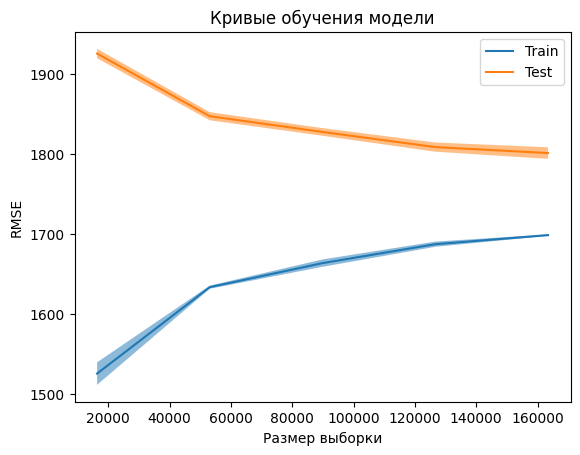

In [69]:
# Рассчёт параметров для построения кривой обучения
train_sizes, train_scores, test_scores = learning_curve(estimator=best_model,
                                                        X=features_train_ohe,
                                                        y=target_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        cv=3,
                                                        scoring='neg_root_mean_squared_error',
                                                        random_state=RANDOM_STATE)
# Визуализация кривой обучения
display = LearningCurveDisplay(train_sizes=train_sizes,
                               train_scores=abs(train_scores),
                               test_scores=abs(test_scores))
fig, ax = plt.subplots()
display.plot(ax=ax);
ax.set_xlabel('Размер выборки')
ax.set_ylabel('RMSE')
ax.set_title('Кривые обучения модели')
fig.show();

**Замечание:** С увеличением количества данных метрика `RMSE` на тесте продолжает уменьшаться. Следовательно у нашей итоговой модели ещё есть потенциал к увеличению точности предсказаний. 

### Оценим важность признаков для работы модели.
Важность признаков будем оценивать методом перестановки `permutation_importance`.   

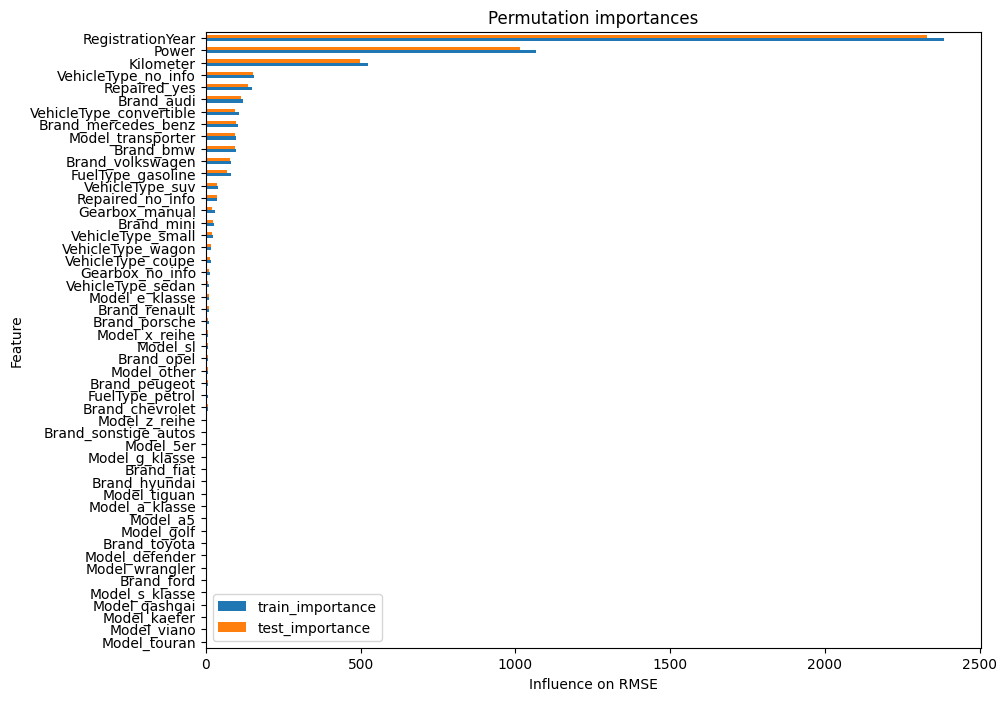

In [70]:
# Получение значений важности признаков для модели машинного обучения на тренировочных данных
train_results = permutation_importance(best_model,
                                       features_train_ohe,
                                       target_train,
                                       scoring='neg_root_mean_squared_error',
                                       n_repeats=5,
                                       random_state=RANDOM_STATE)
# Получение значений важности признаков для модели машинного обучения на тестовых данных
test_results = permutation_importance(best_model,
                                      features_test_ohe,
                                      target_test,
                                      scoring='neg_root_mean_squared_error',
                                      n_repeats=5,
                                      random_state=RANDOM_STATE)
# Создание таблицы со значениями коэффициентов и названиями признаков
feature_importance = pd.DataFrame({'Feature': features_train_ohe.columns,
                                   'train_importance': train_results.importances_mean,
                                   'test_importance': test_results.importances_mean})
# Сортировка значений по убыванию
feature_importance = feature_importance.sort_values('train_importance', ascending=True)
# Построение столбчатого горизонтального графика для 50 наиболее важных признаков
feature_importance.tail(50).plot(kind='barh', x='Feature', figsize=(10, 8))
plt.xlabel('Influence on RMSE');
plt.title('Permutation importances');

**Замечание:**  На графике сверху мы видим признаки оказывающие наибольшее влияние на работу модели. Самое большое влияние оказывает возраст авто (год регистрации), мощьность двигателя и пробег. Это объяснимо и вполне логично.   
Заметим, что на тестовой выборке признаки оказывают немного меньшее влияние на работу алгоритма, чем на тренировочной выборке.  
Также наша модель в большинстве слабо реагирует на бренды и модели авто, за исключением некоторых (среди них немецкие бренды: `audi`, `mercedes_benz`, `bmv` и др.). В будущем можно объединить часть брендов и моделей авто в общие категории, для сокращения признакового пространства.

## Общий вывод

В данном проекте мы построили модель машинного обучения для сервиса по продаже автомобилей с пробегом, на основе исторических данных. 

**Этапы выполнения проекта:**

    
**1. Изучение данных.**  
Сначала мы установили, импортировали нужные библиотеки (модули), загрузили и изучили данные. Обнаружили в них пропуски и аномалии.      

**2. Предобработка данных.**  
На данном этапе мы предварительно обработали наши данные. А именно удалили дубликаты и аномальные значения признаков: `Price`, `Power`, `RegistrationYear`, избавились от неинформативных и бесполезных признаков, заполнили пропуски используя заглушку `no_info`.   

**3. Поиск зависимостей в данных.**  
Здесь мы рассчитали два типа корреляций: `Pirson` и `Phik`, чтобы определить наличие связей между признаками. После чего проанализировали зависимость цены автомобиля от признаков: `VehicleType`,`Gearbox` и `Repaired`.    

**4. Обучение моделей.**  
На этой стадии проекта мы разбили данные на выборки (тренировочную и тестовую), выполнили кодирование категориальных признаков и масштабирование количественных признаков (для работы линейных моделей).
Далее мы проверяли работу 5 типов моделей машинного обучения: `LinearRegression`, `LinearSVR`, `RandomForestRegressor`, `AdaBoostRegressor` и `CatBoostRegressor`. Обучение проводили перебирая гиперпараметры с помощью `RandomizedSearchCV`. После этого для каждого типа моделей выбрали наилучший вариант. Затем проанализировали качество и время работы моделей, и наконец, выбрали итоговый вариант (`CatBoostRegressor`).     

**5. Анализ итоговой модели.**  
На последнем этапе проекта мы проверили итоговую модель на тестовой выборке, после чего проверили её на адекватность.
Далее, построив кривые обучения, определили, что у модели есть потенциал в приросте качества при увеличении количества данных.
В заключение, с помощью метода `permutation_importance`, выделили признаки оказывающие наибольшее влияние на работу нашей модели.

**В итоге:**  
Лучшей моделью оказалась `CatBoostRegressor` с гиперпараметрами: `depth: 8`, `iterations: 99`. Она показала качество на тестовой выборке `RMSE=1773`. Время обучения модели равно `1,9 сек.`, а время предсказания модели равно `0,05 сек.`

**Цель проекта достигнута**